# Airbnb Lisbon Data Analysis

This notebook will analyse public data from airbnb, obtained from http://insideairbnb.com/get-the-data.html. We will look at data from Lisbon, the capital city of Portugal, to answer the following questions:

###### Which neighbourhoods have the most listings, are more expensive and have the most positive reviews?

###### Do super hosts have more positive reviews than regular hosts?

###### What are the factors that most contribute to more positive reviews?



## Table of Contents:
* [Data Sneak Peek](#first-bullet)
* [Neighbourhoods Analysis](#second-bullet)
* [Super Host Analysis](#third-bullet)
* [Review Score Prediction](#fourth-bullet)
    * [NaN values analysis](#fifth-bullet)

### Data Sneak Peek <a class="anchor" id="first-bullet"></a>

In [1]:
# Library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor

# magic word for producing visualizations in notebook
%matplotlib inline

C:\Users\pc-w\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\pc-w\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Functions

def parse_into_float(price_string):
    return float(price_string[1:].replace(',', ''))

def get_true_false_dummy(true_false_string):
    if true_false_string == 't':
        return 1
    elif true_false_string == 'f':
        return 0
    else:
        return np.nan

def parse_lists(list_string):
    list_string = list_string[1:-1]
    list_string = list_string.replace('"', '')
    list_string = list_string.replace(' ', '')
    list_string = list_string.replace('\'', '')
    return list_string.split(',')

def parse_lists_into_count(list_string):
    return len(parse_lists(list_string))

In [3]:
# Get the raw data from the csv file and take a peak
air_bnb_listings_raw = pd.read_csv('listings.csv')
air_bnb_listings_raw.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,24056,https://www.airbnb.com/rooms/24056,20181017033106,2018-10-17,Linda-a-Velha,NaN,A comfortable apartment with pool during the s...,A comfortable apartment with pool during the s...,none,NaN,...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,NaN
1,25659,https://www.airbnb.com/rooms/25659,20181017033106,2018-10-17,"Sunny, Alfama Sleeps 3 - Coeur d'Alfama",Heart of Alfama! Sunny Charming 1 Bedroom apar...,Charming sunny apartment in the heart of Alfam...,Heart of Alfama! Sunny Charming 1 Bedroom apar...,none,Alfama is the oldest and most picturesque quar...,...,t,56539/AL.,"{Lisbon,"" Portugal""}",t,f,moderate,f,f,1,1.7


In [4]:
# Learn the shape of the dataset
print(f'This dataset has {air_bnb_listings_raw.shape[0]} rows and {air_bnb_listings_raw.shape[1]} columns')

# Get some basic information about each of the columns
air_bnb_listings_raw.describe()

This dataset has 22123 rows and 96 columns


,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,2.212300e+04,2.212300e+04,0.0,0.0,0.0,2.212300e+04,0.0,22121.000000,22121.000000,22123.000000,...,22123.000000,18605.000000,18591.000000,18599.000000,18584.000000,18592.000000,18585.000000,18582.000000,22123.000000,18789.000000
mean,1.631487e+07,2.018102e+13,NaN,NaN,NaN,6.721255e+07,NaN,15.411916,15.411916,38.755540,...,33.259865,92.450954,9.527083,9.454756,9.655295,9.678410,9.393489,9.216769,12.259775,1.874947
std,8.490358e+06,2.425836e+00,NaN,NaN,NaN,6.551403e+07,NaN,50.192890,50.192890,0.103668,...,51.666962,8.275162,0.840736,0.867613,0.769299,0.742025,0.790379,0.880603,34.383392,1.695623
min,2.405600e+04,2.018102e+13,NaN,NaN,NaN,1.709600e+04,NaN,0.000000,0.000000,38.675089,...,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.010000
25%,9.251693e+06,2.018102e+13,NaN,NaN,NaN,1.192645e+07,NaN,1.000000,1.000000,38.711027,...,2.000000,90.000000,9.000000,9.000000,9.000000,10.000000,9.000000,9.000000,1.000000,0.520000
50%,1.795770e+07,2.018102e+13,NaN,NaN,NaN,4.070291e+07,NaN,3.000000,3.000000,38.717512,...,11.000000,94.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,3.000000,1.370000
75%,2.360596e+07,2.018102e+13,NaN,NaN,NaN,1.167129e+08,NaN,10.000000,10.000000,38.739007,...,41.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,8.000000,2.850000
max,2.933783e+07,2.018102e+13,NaN,NaN,NaN,2.210216e+08,NaN,422.000000,422.000000,39.301960,...,663.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,274.000000,19.860000


### Neighbourhoods Analysis <a class="anchor" id="second-bullet"></a>

By analysing the graph below, we can see that the 10 neighbourhoods with the most listings are all inside the center of Lisbon,
which is not surprising since the center is by far the most tourism prone area.

In [5]:
nr_listings_per_neighbourhood = air_bnb_listings_raw.groupby(['neighbourhood'])['id'].count()
nr_listings_per_neighbourhood.sort_values(ascending=False).head(10)

neighbourhood
Alfama                  1376
Baixa                    941
São Jorge de Arroios     815
Encarnação               770
Anjos                    725
Santa Catarina           683
São Paulo                679
Mercês                   588
Coração de Jesus         512
Pena                     475
Name: id, dtype: int64

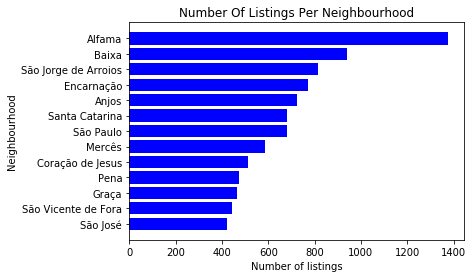

In [6]:
mask0 = nr_listings_per_neighbourhood > 400
nr_listings_per_neighbourhood_sorted = nr_listings_per_neighbourhood.sort_values()
plt.barh(nr_listings_per_neighbourhood_sorted[mask0].index, nr_listings_per_neighbourhood_sorted[mask0], color = 'blue')
plt.xlabel('Number of listings')
plt.ylabel('Neighbourhood')
plt.title('Number Of Listings Per Neighbourhood')
plt.show()
plt.close()

By analysing the graph below, we can see that there is not much of a difference, between the review scores for each of the neighbourhoods.
Therefore, we can conclude that all neighbourhood are well liked by the guests.

In [7]:
review_score_per_neighbourhood = air_bnb_listings_raw.groupby(['neighbourhood'])['review_scores_rating'].mean()         
review_score_per_neighbourhood.sort_values(ascending=False).head(10)

neighbourhood
Charneca                   98.250000
São João de Deus           94.170732
Santa Maria dos Olivais    94.144444
Ajuda                      93.730496
Estrella/Lapa              93.572000
Graça                      93.546988
Belém                      93.526690
São Mamede                 93.512635
São Domingos de Benfica    93.430108
Parque das Nações          93.308642
Name: review_scores_rating, dtype: float64

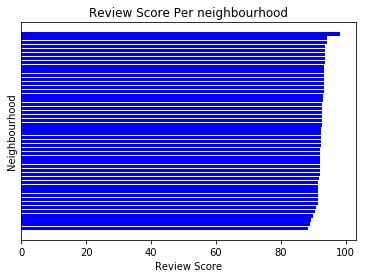

In [8]:
mask0 = review_score_per_neighbourhood > 0
review_score_per_neighbourhood_sorted = review_score_per_neighbourhood.sort_values()
plt.barh(review_score_per_neighbourhood_sorted[mask0].index,review_score_per_neighbourhood_sorted[mask0], color = 'blue')
plt.xlabel('Review Score')
plt.ylabel('Neighbourhood')
plt.title('Review Score Per neighbourhood')
plt.yticks([])
plt.show()
plt.close()

In [9]:


air_bnb_listings_raw['float_price'] = air_bnb_listings_raw['price'].apply(parse_into_float)

By analysing the graph below, we notice that "Bairro Alto" has by far the most expensive price. The neighbourhoods "Benfica", "São Domingos de Benfica" and "Carnide" also have higher prices than average. This might be explained to the fact that "Estádio da Luz", a football stadium that receives a great number of high profile internacional and nacional football games is in their vicinity.

In [10]:
mean_prices_per_neighbourhood = air_bnb_listings_raw.groupby(['neighbourhood'])['float_price'].mean()
mean_prices_per_neighbourhood.sort_values(ascending=False).head(10)

neighbourhood
Bairro Alto                300.000000
Benfica                    210.588785
São Domingos de Benfica    197.346667
Carnide                    149.792683
Baixa                      114.463337
Parque das Nações          112.525806
Encarnação                 108.211688
Santa Isabel               107.295000
São Francisco Xavier       103.100000
Mercês                      98.015306
Name: float_price, dtype: float64

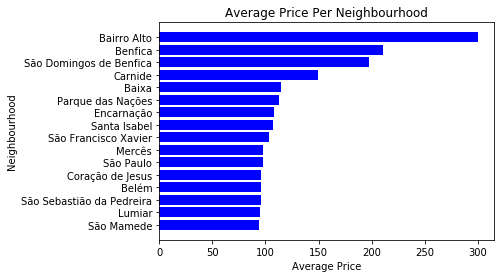

In [11]:
mean_prices_per_neighbourhood_sorted = mean_prices_per_neighbourhood.sort_values()
mask0 = mean_prices_per_neighbourhood_sorted > 90
plt.barh(mean_prices_per_neighbourhood_sorted[mask0].index,mean_prices_per_neighbourhood_sorted[mask0], color = 'blue')
plt.xlabel('Average Price')
plt.ylabel('Neighbourhood')
plt.title('Average Price Per Neighbourhood')
plt.show()
plt.close()

### Super Host Analysis <a class="anchor" id="third-bullet"></a>

As we can see below, super hosts have on average a score of 96, while regular hosts only have an average score of 90. Therefore, it is safe to say that guests are satisfied with super hosts overall.

In [12]:


air_bnb_listings_raw['host_is_superhost_encoded'] = air_bnb_listings_raw['host_is_superhost'].apply(get_true_false_dummy)
print(air_bnb_listings_raw['host_is_superhost_encoded'].unique())

[ 0.  1. nan]


In [13]:
review_score_per_super_user = air_bnb_listings_raw.groupby(['host_is_superhost_encoded'])['review_scores_rating'].mean()         
review_score_per_super_user.sort_values(ascending=False).head(10)

host_is_superhost_encoded
1.0    96.862366
0.0    90.778280
Name: review_scores_rating, dtype: float64

### Review Score Prediction <a class="anchor" id="fourth-bullet"></a>

In the next section we will use logistic regression and forest regression methods in order to try predict the guests' review score based on the other features of the dataset. Afterwhards, feature importance will be analysed based on the results of these regression methods.

### Nan values analysis <a class="anchor" id="fifth-bullet"></a>

The dataset has a total of 29819 NaN values. We will classify any column with more than 60% NaN values an outlier column. By analysing the bar plot below, we can confirm that 60% appears to be the ideal threshold value. The columns with less than 5% NaN values were excluded from the bar plot.

The outlier columns discovered in this step will be dropped from the dataset.

In [14]:
print(f'The total number of nan values in this dataset is {air_bnb_listings_raw.isnull().sum().sum()}')
null_values_per_column = air_bnb_listings_raw.isnull().sum()/air_bnb_listings_raw.shape[0]
print(null_values_per_column.sort_values(ascending=False)[null_values_per_column > .6])

The total number of nan values in this dataset is 312370
xl_picture_url          1.000000
thumbnail_url           1.000000
medium_url              1.000000
host_acceptance_rate    1.000000
square_feet             0.979117
monthly_price           0.906884
weekly_price            0.895087
dtype: float64


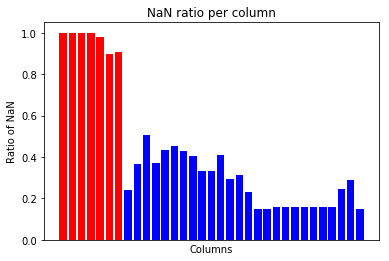

In [15]:
mask0 = null_values_per_column > 0.05
mask1 = null_values_per_column >= 0.6
mask2 = null_values_per_column < 0.6   

plt.bar(null_values_per_column[mask0][mask1].index.values, null_values_per_column[mask0][mask1].values, color = 'red')
plt.xticks([])
plt.bar(null_values_per_column[mask0][mask2].index.values, null_values_per_column[mask0][mask2].values, color = 'blue')
plt.xlabel('Columns')
plt.ylabel('Ratio of NaN')
plt.title('NaN ratio per column')
plt.show()
plt.close()

The previously identified outlier columns will be dropped now.

In [16]:
# Drop the outlier columns
outlier_columns = ['xl_picture_url', 'thumbnail_url', 'medium_url', 'host_acceptance_rate', \
           'square_feet', 'monthly_price', 'weekly_price']
air_bnb_listings = air_bnb_listings_raw.drop(outlier_columns, axis=1)

# Also drop the original price and is_super_host columns, since now we have the dummies
to_drop = ['price', 'host_is_superhost']
air_bnb_listings = air_bnb_listings.drop(to_drop, axis=1)

# Next we will drop columns which are not relevant to the analysis, like names, ids,
# free text fields and image urls.
to_drop = ['id', 'listing_url', 'scrape_id', 'name', 'summary', 'space', 'description', 'neighborhood_overview', \
          'notes', 'transit', 'access', 'interaction', 'house_rules', 'picture_url', \
          'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_thumbnail_url', \
          'host_picture_url', 'host_total_listings_count', 'street', 'state', 'zipcode', 'market', 'smart_location', \
          'country_code', 'country', 'latitude', 'longitude', 'calendar_updated', 'first_review', 'last_review', \
          'license', 'jurisdiction_names', 'calendar_last_scraped', 'last_scraped', 'host_neighbourhood', \
          'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city']
air_bnb_listings = air_bnb_listings.drop(to_drop, axis=1)

In [17]:
# Print the shape of the dataset after dropping the columns
air_bnb_listings.shape

(22123, 46)

In [18]:
# Drop all rows with na values and print the shape of the dataset again
air_bnb_listings_no_na = air_bnb_listings.dropna()
air_bnb_listings_no_na.shape

(6576, 46)

In [19]:
# Drop these columns because all the rows have the same value
to_drop = ['is_business_travel_ready', 'experiences_offered', 'has_availability']
air_bnb_listings_no_na = air_bnb_listings_no_na.drop(to_drop, axis=1)

### Encoding <a class="anchor" id="sixth-bullet"></a>

The remaining mixed type columns will be reengineered and the categorical columns will be encoded.

In [20]:
# Figure out which are the categorical columns and the mixed type columns so that they can be handled appropriately
cat_air_bnb_listings_no_na = air_bnb_listings_no_na.select_dtypes(include=['object'])
print(cat_air_bnb_listings_no_na.columns)

Index(['host_response_time', 'host_response_rate', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'is_location_exact', 'property_type', 'room_type', 'bed_type',
       'amenities', 'security_deposit', 'cleaning_fee', 'extra_people',
       'requires_license', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification'],
      dtype='object')


In [21]:
# Encode true/false columns
columns_to_encode = ['host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'instant_bookable', \
                    'require_guest_profile_picture', 'require_guest_phone_verification', 'requires_license']

for column_to_encode in columns_to_encode:
    air_bnb_listings_no_na[column_to_encode] = air_bnb_listings_no_na[column_to_encode].apply(get_true_false_dummy)


In [22]:
# Encode price columns
columns_to_encode = ['security_deposit', 'cleaning_fee', 'extra_people' ]

for column_to_encode in columns_to_encode:
    air_bnb_listings_no_na[column_to_encode] = air_bnb_listings_no_na[column_to_encode].apply(parse_into_float)

The Amenities column has incredibly dirty data because the same amenity can have many different names. Therefore, instead of trying to create dummy columns for each amenity, we will count how many amenities each listing has and encode it into a new column.

In [23]:
# Generate new column for the number of amenities per listing. Drop the old amenities column
air_bnb_listings_no_na['amenities_count'] = air_bnb_listings_no_na['amenities'].apply(parse_lists_into_count)
air_bnb_listings_no_na = air_bnb_listings_no_na.drop(['amenities'], axis = 1)

In [24]:
# Generate a new column for each type of host verification using the MultiLabelBinarizer
air_bnb_listings_no_na['host_verifications_enc'] = air_bnb_listings_no_na['host_verifications'].apply(parse_lists)

mlb = MultiLabelBinarizer()

print('Shape of the dataframe before encoding host_verifications:')
print(air_bnb_listings_no_na.shape)

air_bnb_listings_no_na = air_bnb_listings_no_na.join(pd.DataFrame(mlb.fit_transform(air_bnb_listings_no_na.pop('host_verifications_enc')),
                          columns=mlb.classes_,
                          index=air_bnb_listings_no_na.index).add_prefix('host_verification_'))

air_bnb_listings_no_na = air_bnb_listings_no_na.drop(['host_verifications'], axis=1)

print('Shape of the dataframe after encoding host_verifications:')
print(air_bnb_listings_no_na.shape)

Shape of the dataframe before encoding host_verifications:
(6576, 44)
Shape of the dataframe after encoding host_verifications:
(6576, 60)


Let's check what columns we have on the dataset now:

In [25]:
air_bnb_listings_no_na.columns

Index(['host_response_time', 'host_response_rate', 'host_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'reviews_per_month', 'float_price', 'host_is_superhost_encoded',
       'amenities_count', 'host_veri

In [26]:
# Are there any categorical columns left to handle?
cat_air_bnb_listings_no_na = air_bnb_listings_no_na.select_dtypes(include=['object'])
print(cat_air_bnb_listings_no_na.columns)

Index(['host_response_time', 'host_response_rate', 'neighbourhood',
       'property_type', 'room_type', 'bed_type', 'cancellation_policy'],
      dtype='object')


In [27]:
# Inspect the shape of the dataset before encoding
air_bnb_listings_no_na.shape

(6576, 60)

In [28]:
# Encode the remaining categorical columns
air_bnb_listings_no_na = pd.get_dummies(columns = cat_air_bnb_listings_no_na.columns.values, data = air_bnb_listings_no_na)

In [29]:
# Inspect the shape of the dataset after encoding
air_bnb_listings_no_na.shape

(6576, 186)

In [30]:
# Are there any categorical columns left to handle?
cat_air_bnb_listings_no_na = air_bnb_listings_no_na.select_dtypes(include=['object'])
print(cat_air_bnb_listings_no_na.columns)

Index([], dtype='object')


### Scaling <a class="anchor" id="seventh-bullet"></a>

Since there are no more categorical columns to handle, we will apply standard scaling to the data next.

In [31]:
# Apply Scaling
scaler = StandardScaler(with_mean=True, with_std=True)
air_bnb_listings_no_na[air_bnb_listings_no_na.columns] = scaler.fit_transform(air_bnb_listings_no_na[air_bnb_listings_no_na.columns])

In [32]:
# Check if the data looks good
air_bnb_listings_no_na.head(2)

,host_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,...,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
1,-0.445458,0.027585,1.384264,0.788988,-0.504726,-0.437708,-0.577925,-0.25463,0.106185,-0.182543,...,-0.012333,-0.024671,-0.03702,-0.080174,0.092677,-0.358524,1.286816,-1.009473,-0.063004,-0.03022
8,-0.394965,0.027585,1.384264,-1.267447,-0.504726,-0.437708,-0.577925,-0.25463,1.673633,0.072742,...,-0.012333,-0.024671,-0.03702,-0.080174,0.092677,-0.358524,-0.777112,0.990616,-0.063004,-0.03022


In [33]:
air_bnb_listings_no_na.columns

Index(['host_listings_count', 'host_has_profile_pic', 'host_identity_verified',
       'is_location_exact', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'security_deposit', 'cleaning_fee',
       ...
       'bed_type_Airbed', 'bed_type_Couch', 'bed_type_Futon',
       'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict_14_with_grace_period',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60'],
      dtype='object', length=186)

In [34]:
y_true = air_bnb_listings_no_na['review_scores_rating']
features = air_bnb_listings_no_na.drop(['review_scores_rating', 'review_scores_value', \
                                        'review_scores_accuracy', 'review_scores_cleanliness', \
                                        'review_scores_communication', 'review_scores_checkin', \
                                        'review_scores_location'], axis = 1)

In [35]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    y_true, 
                                                    test_size = 0.1, 
                                                    random_state = 5)
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 5918 samples.
Testing set has 658 samples.


In [ ]:
clf = RandomForestRegressor(random_state=5)

parameters = { 'criterion' : ['mse', 'mae'], \
               'max_depth': [5, 10, 25, 40], \
               #'max_features': [2, 3], \
               #'min_samples_leaf': [3, 4, 5], \
               #'min_samples_split': [8, 10, 12], \
               'n_estimators': [10, 20, 30, 50]}

scorer = make_scorer(r2_score)

grid_obj = GridSearchCV(clf, param_grid = parameters, scoring=scorer)

grid_fit = grid_obj.fit(X_train, y_train)

best_clf = grid_fit.best_estimator_
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
best_predictions = best_clf.predict(X_test)
print(f'(Unoptimized) r_2 score is: {r2_score(y_test, y_pred)}')
print(f'(Optimized) r_2 score is: {r2_score(y_test, best_predictions)}')


In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt


In [ ]:
title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = best_clf
plot_learning_curve(estimator, title, features, y_true, ylim=(0.0, 1.01), cv=cv, n_jobs=4)

In [ ]:
features_for_graph = features.columns[:features.shape[1]]
importances = grid_fit.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices[-10:])), importances[indices[-10:]], color='b', align='center')
plt.yticks(range(len(indices[-10:])), features_for_graph[indices[-10:]])
plt.xlabel('Relative Importance');
print(indices[-10:])